In [82]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import gdal
import scipy as sp

#import cartopy
#import imageio

In [2]:
s_time = datetime(2019,1,26,0)
e_time = datetime(2020,2,8,0)

lat0 = -10
lat1 = -30
lon0 = 135
lon1 = 155
res = 0.05


In [3]:
# path for HIMAWARI (after running Pablos algorthim to stack nc files)
path_him = '/g/data1a/oe9/user/ds4491/Him_Extract_Test/HIM8_TWNV_SE_2019.nc'

path_awap = '/g/data1a/oe9/user/data/gridded_rainfall_0.05deg/rain_day_2019_Actual_day.nc'


In [4]:
him = xr.open_dataset(path_him)

In [5]:


him['f1'] = (him['B14']<=230)
him['f2'] = (him['B8']-him['B12'])>= -10

him['mask_n'] = him['f1']*1 + him['f2']*1

In [6]:
him['f3'] = (him['B8']-him['B10'])>= -7
him['f4'] = (him['B16']-him['B14'])>= -5

him['mask_n'] = him['mask_n']*1 + him['f3']*1 + him['f4']*1

In [7]:
him['f5'] = (him['B15']-him['B14'])>= -1.5
him['f6'] = (him['B11']-him['B14'])>= 2

him['mask_n'] = him['mask_n']*1 + him['f5']*1 + him['f6']*1

In [8]:
him['f7'] = (((him['B8']+him['B13'])/2)-273) <= -35
him['mask_n'] = him['mask_n'] + him['f7']*1


In [75]:
him['mask']= him['mask_n']>=5

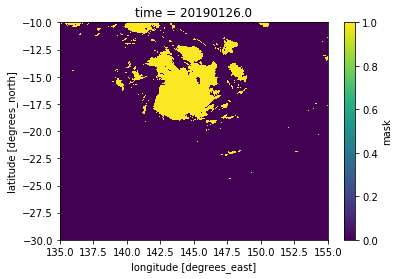

In [77]:
him2 = him.copy()
him2.time.values = np.round(him2.time)
index_time = np.unique(him2.time.values, return_index=True)
him2[['mask']].isel(time = index_time[1])
him3=him2[['mask']].isel(time = index_time[1]).copy()
him3

<xarray.Dataset>
Dimensions:  (lat: 1000, lon: 1000, time: 15)
Coordinates:
  * lon      (lon) float64 135.0 135.0 135.1 135.1 ... 154.9 154.9 155.0 155.0
  * lat      (lat) float64 -10.01 -10.03 -10.05 -10.07 ... -29.95 -29.97 -29.99
  * time     (time) float64 2.019e+07 2.019e+07 ... 2.019e+07 2.019e+07
Data variables:
    mask     (time, lat, lon) bool True True True True ... False False False
Attributes:
    CDI:          Climate Data Interface version 1.9.5 (http://mpimet.mpg.de/...
    Conventions:  CF-1.5
    history:      Wed Feb 12 16:01:59 2020: cdo mergetime aux.nc batch.nc HIM...
    GDAL:         GDAL 2.2.2, released 2017/09/15
    NCO:          netCDF Operators version 4.7.7 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.5 (http://mpimet.mpg.de/...

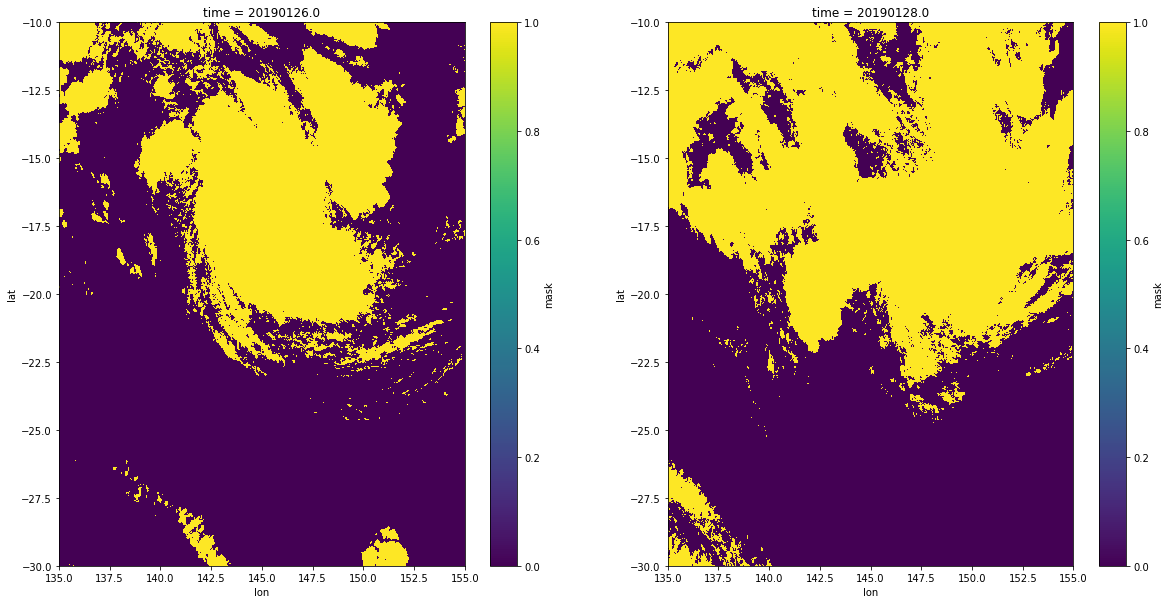

In [102]:

#np.logical_and(filter.sel(time = slice()))
him2 = him.copy()
him2.time.values = np.round(him2.time)
#him2.sel(time=20190126)

index_time = np.unique(him2.time.values, return_index=True)

him3=him2[['mask']].isel(time = index_time[1]).copy()

lat = him3['lat'].values
lon = him3['lon'].values
time = him3['time'].values


for ii in np.arange(len(him3.time.values)):
    
    mask = np.any(np.stack(him2['mask'].sel(time=him3.time.values[ii]).values),axis = 0)
    
    if ii==0:
        mask_all = mask.copy()
        mask_all = np.expand_dims(mask_all,axis=0)
    else:
        mask = np.expand_dims( mask,axis=0)
        mask_all= np.append( mask_all,mask,axis=0)

        
#print(him3)
him4 = xr.Dataset({'mask': (['time', 'lat', 'lon'],  mask_all)},coords={ 'lon': lon, 'lat': lat, 'time': time})

#print(him4)
fig, axes = plt.subplots(ncols=2,figsize=(20,10))


him4['mask'].isel(time=0).plot(ax=axes[0])

him4['mask'].isel(time=2).plot(ax=axes[1])

In [170]:
aa = np.array([[False, False], [False,True]])
np.any(aa, axis=0)

array([False,  True])

In [83]:
#him = xr.open_dataset(path_him)

awap= xr.open_dataset(path_awap)
awap = awap.sel(time = slice(s_time,e_time),latitude = slice(lat0,lat1),longitude= slice(lon0,lon1))
awap

#awap['rain_day'].sel(time=datetime(2019,1,28,0)).plot(figsize = (8,6))

<xarray.Dataset>
Dimensions:    (latitude: 401, longitude: 381, time: 340)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-26 2019-01-27 ... 2019-12-31
  * latitude   (latitude) float64 -10.0 -10.05 -10.1 ... -29.9 -29.95 -30.0
  * longitude  (longitude) float64 135.0 135.1 135.1 135.2 ... 153.9 153.9 154.0
Data variables:
    rain_day   (time, latitude, longitude) float32 ...
Attributes:
    var_name:       rain_day
    title:          Australian Landscape Water Balance AWRA-L Model
    Description:    This data is provided by the Bureau of Meteorology and ca...
    summary:        Data produced by Bureau of Meteorology Australian Water R...
    source:         AWRA-L
    date_created:   2020-02-11T18:43:17
    Conventions:    CF-1.6, ACDD-1.3
    institution:    Bureau of Meteorology
    email:          awrams@bom.gov.au
    url:            http://www.bom.gov.au/water/landscape
    date_modified:  2020-02-11T18:44:27

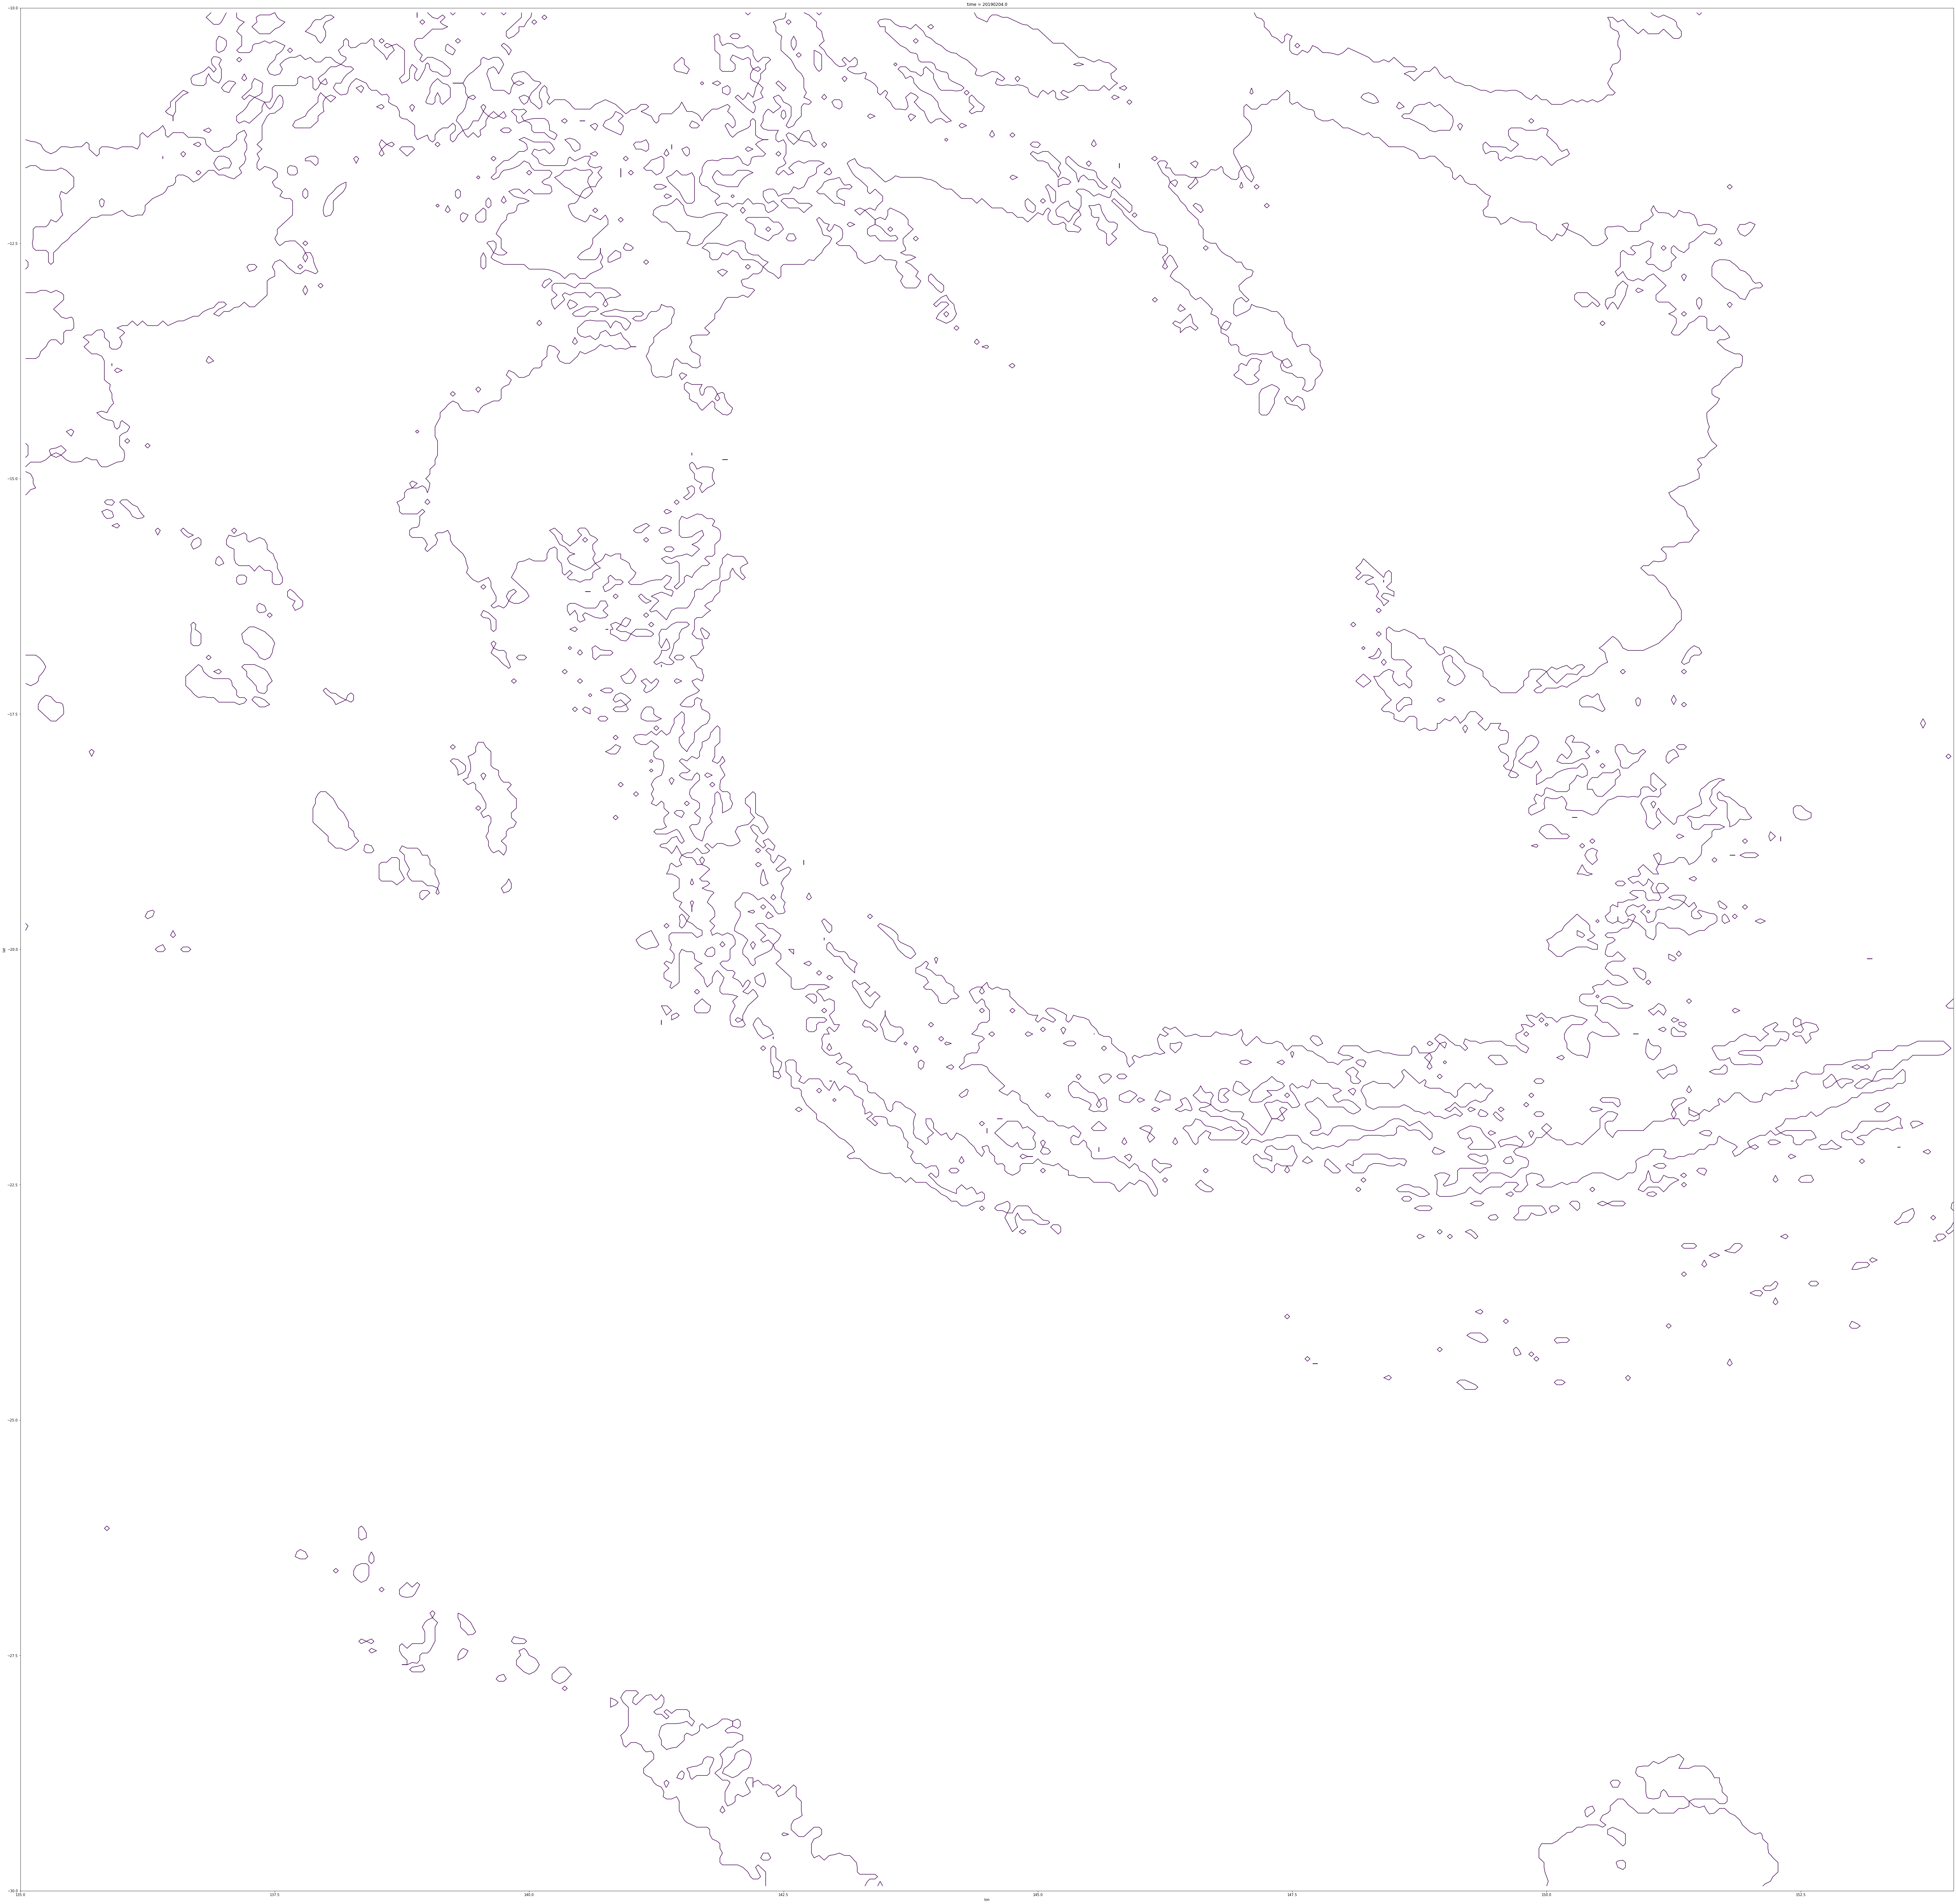

In [98]:
awap_lat = awap['latitude'].data
awap_lon = awap['longitude'].data

him4['mask']=him4['mask']*1
mask_resamp = him4.mask.interp(lat = awap_lat, lon = awap_lon)

mask_resamp.isel(time=10).plot.contour(levels=1,figsize=(100,100))